<h1 align=center>Eigenfashion</h1>

## Download and Extract the Data

In [0]:
!wget -q https://course-resources.minerva.kgi.edu/uploaded_files/mke/nA93zn/male-clothing.zip
!wget -q https://course-resources.minerva.kgi.edu/uploaded_files/mke/VL14ar/female-clothing.zip
!unzip -q male-clothing.zip
!unzip -q female-clothing.zip
!rm *.zip

## Import Libraries and Helper Functions

In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import warnings
warnings.simplefilter("ignore")

from glob import glob #find and traverse path names
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
%matplotlib inline

from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport, ClassPredictionError

## Function to Convert an Image to a Numpy Array

In [0]:
import matplotlib.image as mpimg
from skimage.transform import resize
plt.rcParams['figure.figsize'] = (12, 8) #set plot size


def extract_feature(dir_path): 
  img = mpimg.imread(dir_path)
  img = img / 255.0 # normalize pixel values
  img = resize(img, (128,128, 3)) # convert all images to (128x128x3)
  img = np.reshape(img, (128, 384))
  return img

## Preprocess Data

In [0]:
# store filepaths
female_clothing = glob("Woman's Clothing - n04596852/*") 
male_clothing = glob("Man's Clothing - n03746330/*")

female_clothing_data = [extract_feature(filename) for filename in female_clothing]
male_clothing_data = [extract_feature(filename) for filename in male_clothing]

all_clothing = np.concatenate((np.array(female_clothing_data),
                               np.array(male_clothing_data)))

all_clothing = all_clothing.reshape(all_clothing.shape[0],
                                    np.product(all_clothing.shape[1:]))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(all_clothing)

#standardize data to 0 mean and unit variance
all_clothing = scaler.transform(all_clothing)

## Create Train/Test Splits

In [0]:
from sklearn.model_selection import train_test_split

num_female = len(female_clothing_data)
num_male = len(male_clothing_data)

#set target
classes = [1] * num_female + [0] * num_male

X_train, X_test, y_train, y_test = train_test_split(all_clothing, classes, test_size=0.2, 
                                                    stratify=classes, random_state=1)

## Check for Class Imbalance

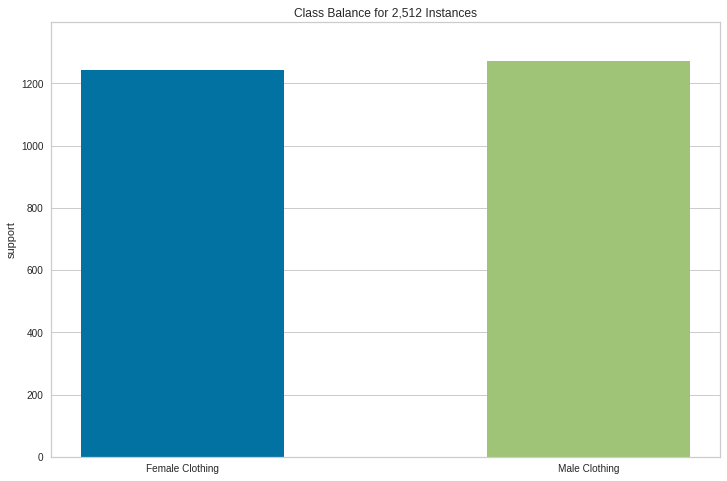

In [6]:
y = np.array(classes)
plt.rcParams['figure.figsize'] = (12, 8)
visualizer = ClassBalance(labels=["Female Clothing", "Male Clothing"])
visualizer.fit(y)
visualizer.poof()

## Perform PCA with 64 Components

In [7]:
pca_top_64_train = PCA(n_components=64, whiten=True, copy=True)
pca_transformed_train = pca_top_64_train.fit_transform(X_train)
print(pca_transformed_train.shape)
print('Variance explained by the top 64 components:', sum(pca_top_64_train.explained_variance_ratio_[:64]))
pca_transformed_test = pca_top_64_train.transform(X_test)

(2009, 64)
Variance explained by the top 64 components: 0.8170239453554392


## Use PCA-Transformed Data as Input For Classification with XGBoost

In [8]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=100,
                        max_depth=3,
                        objective= 'binary:logistic',
                        seed=1,
                        tree_method='gpu_hist',
                        metric='auc',
                        n_jobs=-1)
clf.fit(pca_transformed_train, y_train, eval_set=[(pca_transformed_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3, metric='auc',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [9]:
print('Train accuracy:', sum(clf.predict(pca_transformed_train) == y_train) / pca_transformed_train.shape[0])
print('Test accuracy:', sum(clf.predict(pca_transformed_test) == y_test) / X_test.shape[0])

Train accuracy: 0.8641114982578397
Test accuracy: 0.6540755467196819


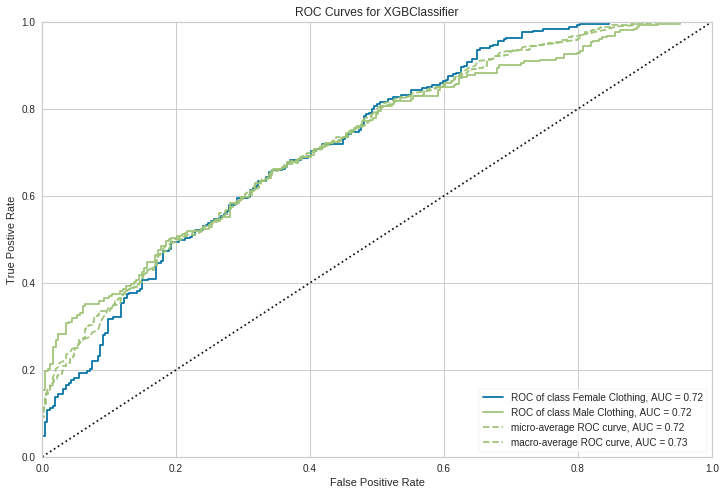

In [10]:
visualizer = ROCAUC(clf, classes=["Female Clothing", "Male Clothing"])

visualizer.fit(pca_transformed_train, y_train)        
visualizer.score(pca_transformed_test, y_test)        
visualizer.poof()

## Exploratory Data Analysis

(128, 128, 3)


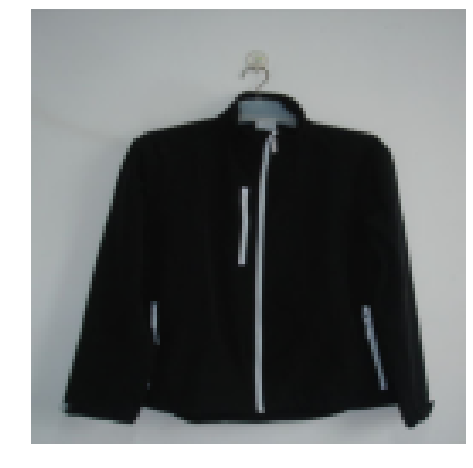

In [11]:
import matplotlib.image as mpimg
from skimage.transform import resize

img = mpimg.imread("Man's Clothing - n03746330/n03746330_1041.JPEG")
img = img / 255.0
img = resize(img, (128, 128, 3))
print(img.shape)
plt.axis('off')
plt.imshow(img);

In [12]:
img_r = np.reshape(img, (128, 384))
print(img_r.shape)

(128, 384)


In [13]:
ipca = PCA(10).fit(img_r)
img_c = ipca.transform(img_r)
print(img_c.shape)
print(np.sum(ipca.explained_variance_ratio_))

(128, 10)
0.9797968842523112


In [14]:
temp = ipca.inverse_transform(img_c)
print(temp.shape)

temp = np.reshape(temp, (128,128,3))
print(temp.shape)

(128, 384)
(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


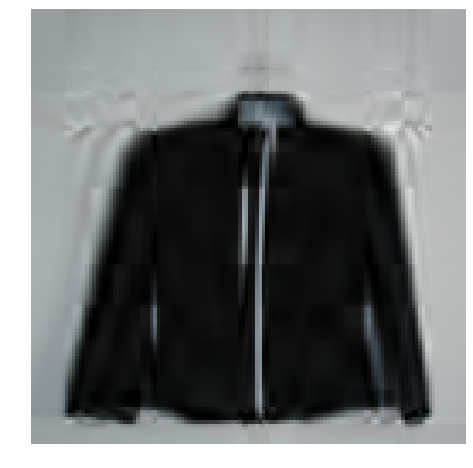

In [15]:
plt.axis('off')
plt.imshow(temp);